In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchinfo import summary
import torchvision.models as models

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for evaluation
from sklearn.metrics import confusion_matrix, classification_report




In [2]:
# Check for GPU availability
if torch.cuda.is_available():
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using CPU.")

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Currently using device: {device}")


CUDA is available. Using GPU: NVIDIA GeForce GTX 1650 Ti
Currently using device: cuda


In [3]:
# Create datasets using ImageFolder for training, validation, and test sets.
# Separate transformations are applied: training data undergoes augmentation (flips, rotations),
# while validation and test data are only normalized for evaluation.

# Transform for training data (with augmentations)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform for validation and test data (without augmentations)
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets using ImageFolder
train_data = ImageFolder(root="/Users/muzaf/OneDrive/Masaüstü/BI2/Term_project/100image/train", transform=train_transforms)
validation_data = ImageFolder(root="/Users/muzaf/OneDrive/Masaüstü/BI2/Term_project/100image/valid", transform=test_transforms)
test_data = ImageFolder(root="/Users/muzaf/OneDrive/Masaüstü/BI2/Term_project/100image/test", transform=test_transforms)

# Verify dataset sizes
len(train_data), len(validation_data), len(test_data)


(13492, 500, 500)

In [4]:

# Create DataLoaders for training, validation, and test datasets.
# num_workers is set to 4 for parallel data loading.
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True, num_workers=4)
validation_dataloader = DataLoader(dataset=validation_data, batch_size=32, shuffle=False, num_workers=4)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False, num_workers=4)

# Print the number of batches in each dataloader
print(f"Training batches: {len(train_dataloader)}")
print(f"Validation batches: {len(validation_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")


Training batches: 422
Validation batches: 16
Test batches: 16


In [5]:

def visualize(dataloader, classes=None):
    images, labels = next(iter(dataloader))  # Get a batch of images and labels
    print("Images batch shape:", images.shape)  # Check if images are loaded correctly
    print("Labels:", labels)  # Debugging step to ensure labels are loaded correctly
    
    grid = make_grid(images, nrow=8, normalize=True)  # Create a grid of images
    plt.figure(figsize=(16, 16))  # Set the figure size for better display
    plt.imshow(np.transpose(grid, (1, 2, 0)))  # Transpose image to display correctly
    
    # If classes are provided, print the corresponding labels
    if classes:
        print('Labels:', [classes[label] for label in labels])
    
    # Save and display the plot
    plt.savefig('image_grid.png')  # Save to check if it's being created correctly
    plt.show()  # Display the image grid



Images batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([44, 40, 62, 26, 27, 76, 70, 30, 49, 65, 64, 63, 74, 31, 29, 24, 57, 53,
        63, 35, 68, 92, 85, 59, 70, 10, 73, 33, 36, 65,  8, 79])
Labels: ['horseshoe pitching', 'high jump', 'pole dancing', 'field hockey', 'figure skating men', 'ski jumping', 'rowing', 'fly fishing', 'jai alai', 'pommel horse', 'polo', 'pole vault', 'shuffleboard', 'football', 'figure skating women', 'disc golf', 'mushing', 'lacrosse', 'pole vault', 'giant slalom', 'roller derby', 'uneven bars', 'swimming', 'olympic wrestling', 'rowing', 'bike polo', 'shot put', 'frisbee', 'golf', 'pommel horse', 'basketball', 'snow boarding']


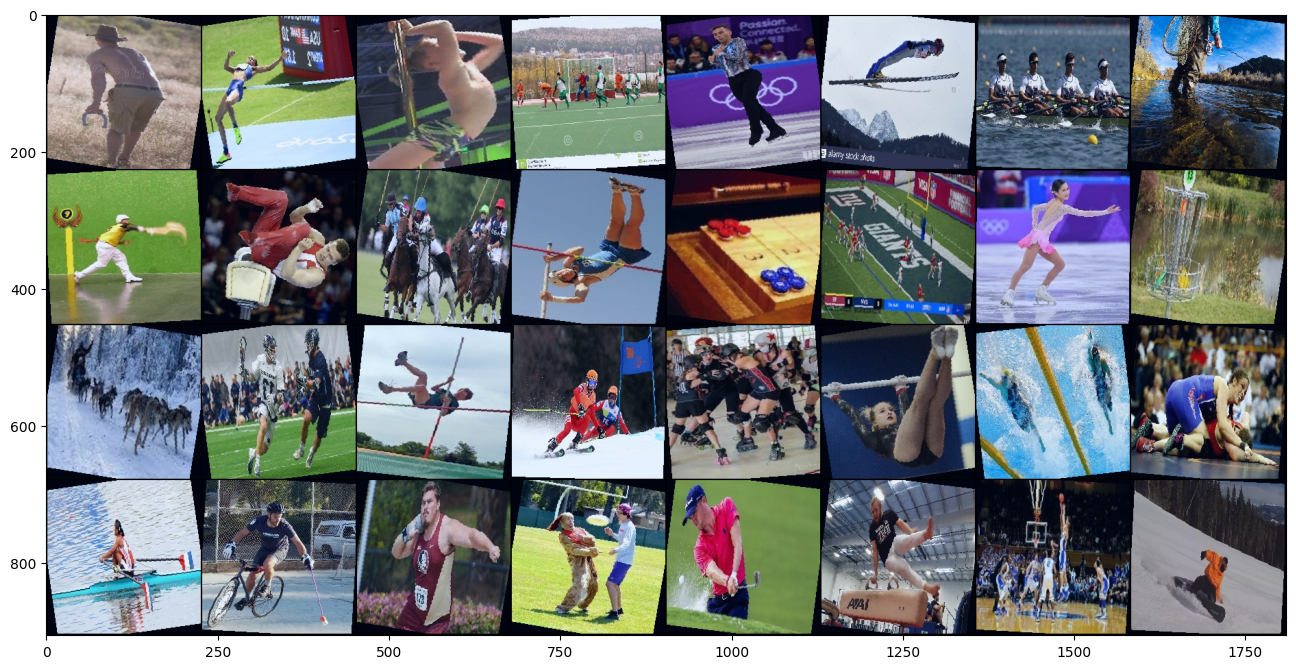

In [6]:
visualize(train_dataloader, classes=train_data.classes)


Images batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([18, 35, 17, 96, 41, 14, 84, 73, 62, 51, 24, 13, 79, 40,  5, 29, 70, 30,
        27,  1, 12, 74, 30, 78, 57, 89, 91, 27,  1, 94, 85, 97])


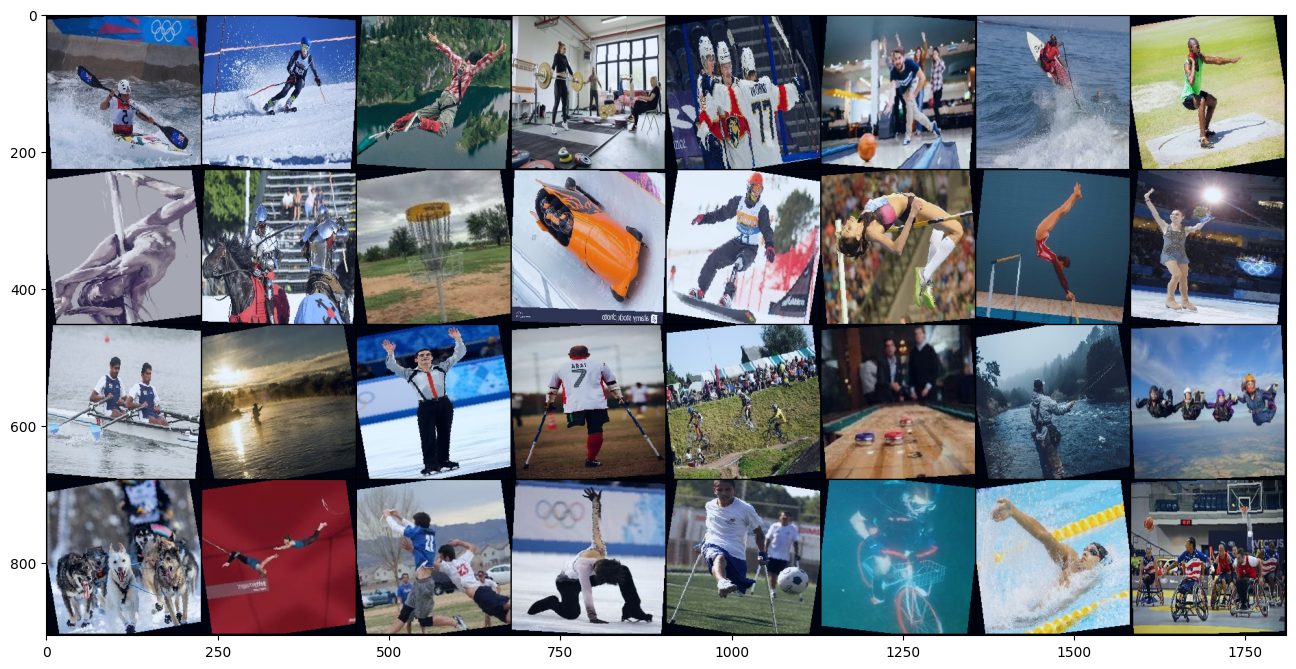

In [7]:
# visualize train data
visualize(train_dataloader)

Images batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 6, 6])


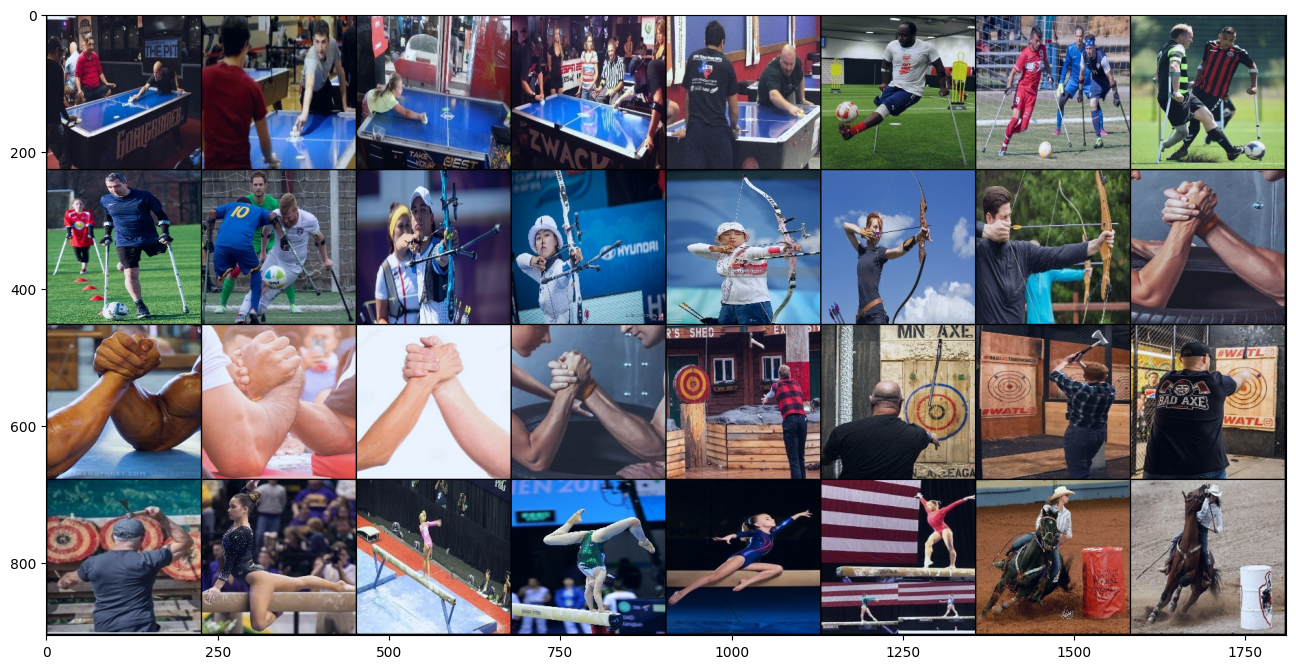

In [8]:
# visulize valid data
visualize(validation_dataloader)

Images batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 6, 6])


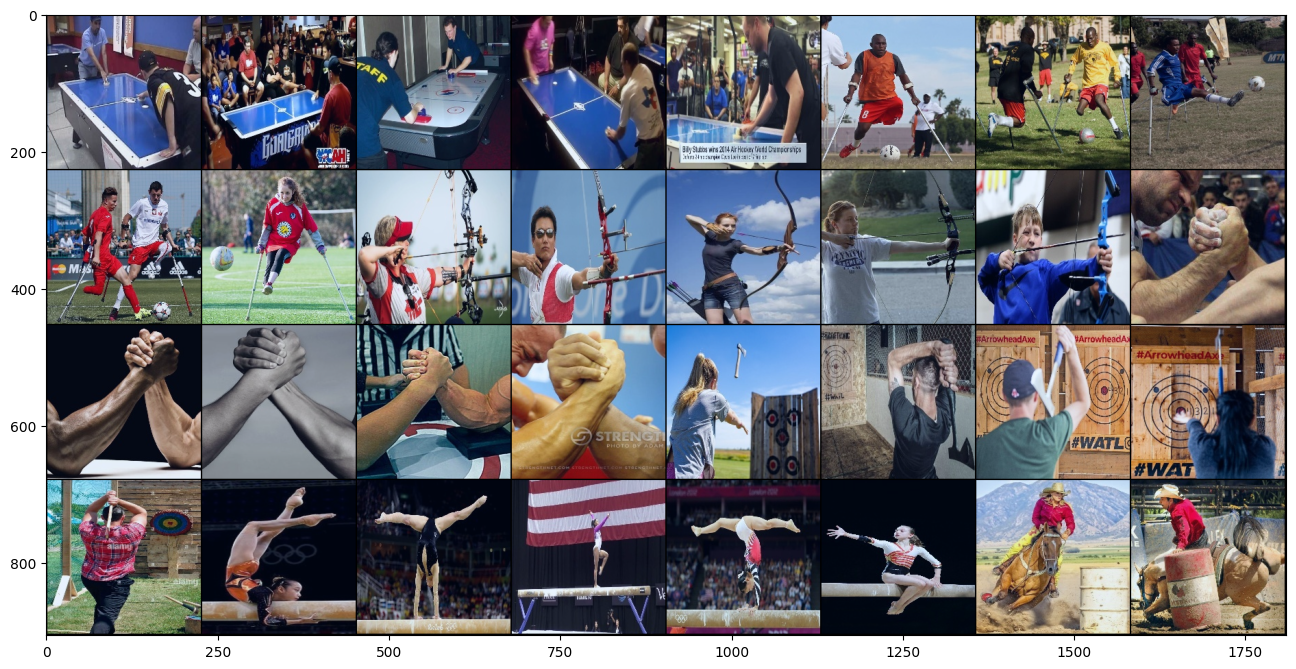

In [9]:
#visualize test data
visualize(test_dataloader)

In [10]:
from torchinfo import summary

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100, use_batch_norm=False):
        super(SimpleCNN, self).__init__()

        # Define the convolutional layers
        layers = []
        layers.append(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(96))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=3, stride=2))

        layers.append(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(256))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=3, stride=2))

        layers.append(nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(384))
        layers.append(nn.ReLU())

        layers.append(nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(384))
        layers.append(nn.ReLU())

        layers.append(nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1))
        if use_batch_norm:
            layers.append(nn.BatchNorm2d(256))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=3, stride=2))

        # Use adaptive pooling to ensure the output size is always the same, regardless of input image size
        self.conv_layers = nn.Sequential(*layers)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))  # Reduce the output to (6,6) feature map size

        # Define fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),  # Output of the adaptive pooling
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=4096, out_features=2048),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(in_features=2048, out_features=num_classes)  # Final output layer for classification
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Pass through the convolutional layers
        x = self.adaptive_pool(x)  # Apply adaptive pooling
        x = self.fc_layers(x)  # Pass through the fully connected layers
        return x

# Create an instance of the model
model = SimpleCNN(num_classes=100, use_batch_norm=True)

# Print a summary of the model
summary(model, input_size=(32, 3, 224, 224))  # Assuming batch size of 32 and image size of 224x224


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 100]                 --
├─Sequential: 1-1                        [32, 256, 5, 5]           --
│    └─Conv2d: 2-1                       [32, 96, 54, 54]          34,944
│    └─BatchNorm2d: 2-2                  [32, 96, 54, 54]          192
│    └─ReLU: 2-3                         [32, 96, 54, 54]          --
│    └─MaxPool2d: 2-4                    [32, 96, 26, 26]          --
│    └─Conv2d: 2-5                       [32, 256, 26, 26]         614,656
│    └─BatchNorm2d: 2-6                  [32, 256, 26, 26]         512
│    └─ReLU: 2-7                         [32, 256, 26, 26]         --
│    └─MaxPool2d: 2-8                    [32, 256, 12, 12]         --
│    └─Conv2d: 2-9                       [32, 384, 12, 12]         885,120
│    └─BatchNorm2d: 2-10                 [32, 384, 12, 12]         768
│    └─ReLU: 2-11                        [32, 384, 12, 12]         -

In [11]:

model = SimpleCNN(num_classes=100).to(device)

# Test with a random input, assuming input size 224x224
x = torch.randn(32, 3, 224, 224).to(device)  # Batch of 32 images, 3 channels, 224x224 size
output = model(x)
print(output.shape)  # Should be [32, 100] indicating batch size of 32 and 100 class predictions




torch.Size([32, 100])


In [12]:
# Optimization Setup
# ------------------
# The Adam optimizer is chosen for its adaptive learning rate properties, which helps
# accelerate convergence, especially in deep networks like CNNs. The learning rate is set to 0.001,
# which is a standard starting point but can be tuned later based on model performance.
# 
# CrossEntropyLoss is used as the loss function since this is a multi-class classification problem
# where the model needs to predict one of 100 sports categories. It combines softmax and 
# negative log-likelihood loss, making it suitable for such tasks.
#
# During training, the optimizer will update the model's weights based on the gradients
# computed using the loss between the model's predictions and the true labels.


optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [13]:
# Train the model
epochs = 20

training_loss = []
validation_loss = []

for epoch in range(epochs):

    # Training phase
    model.train()
    epoch_train_loss = 0.0
    for images, labels in train_dataloader:
        # Move data to the appropriate device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients from the previous step
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        batch_train_loss = loss_fn(outputs, labels)

        # Backward pass: compute gradient of the loss with respect to model parameters
        batch_train_loss.backward()
        optimizer.step()

        # Accumulate training loss, multiplying by batch size to get total loss
        epoch_train_loss += batch_train_loss.item() * images.size(0)

    # Average training loss for the epoch
    epoch_train_loss /= len(train_dataloader.dataset)
    training_loss.append(epoch_train_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for val_images, val_labels in validation_dataloader:
            # Move validation data to the appropriate device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Forward pass for validation
            val_outputs = model(val_images)
            batch_val_loss = loss_fn(val_outputs, val_labels)
            epoch_val_loss += batch_val_loss.item() * val_images.size(0)

            # Calculate accuracy: compare predicted class to true label
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    # Average validation loss for the epoch
    epoch_val_loss /= len(validation_dataloader.dataset)
    validation_loss.append(epoch_val_loss)

    # Calculate validation accuracy
    val_accuracy = 100 * correct / total

    # Print epoch details: training loss, validation loss, and validation accuracy
    print(f"Epoch: {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Epoch: 1/20, Training Loss: 4.4621, Validation Loss: 4.2548, Validation Accuracy: 3.00%
Epoch: 2/20, Training Loss: 4.1347, Validation Loss: 3.9035, Validation Accuracy: 8.00%
Epoch: 3/20, Training Loss: 3.7276, Validation Loss: 3.4007, Validation Accuracy: 16.00%
Epoch: 4/20, Training Loss: 3.2919, Validation Loss: 2.9636, Validation Accuracy: 26.40%
Epoch: 5/20, Training Loss: 2.9453, Validation Loss: 2.7851, Validation Accuracy: 28.60%
Epoch: 6/20, Training Loss: 2.6684, Validation Loss: 2.4444, Validation Accuracy: 38.00%
Epoch: 7/20, Training Loss: 2.4120, Validation Loss: 2.2121, Validation Accuracy: 44.20%
Epoch: 8/20, Training Loss: 2.1794, Validation Loss: 2.1247, Validation Accuracy: 43.40%
Epoch: 9/20, Training Loss: 1.9783, Validation Loss: 1.9483, Validation Accuracy: 49.20%
Epoch: 10/20, Training Loss: 1.7937, Validation Loss: 1.8690, Validation Accuracy: 52.00%
Epoch: 11/20, Training Loss: 1.6014, Validation Loss: 1.7923, Validation Accuracy: 53.00%
Epoch: 12/20, Trainin

In [14]:
# Save the model after training
torch.save(model.state_dict(), "model_weights.pth")

# Load the model weights (make sure the model architecture is the same)
model = SimpleCNN(num_classes=100).to(device)  # Recreate the model architecture
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()  # Set the model to evaluation mode

C:\Users\muzaf\AppData\Local\Temp\ipykernel_17812\862907260.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pth"))


SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): 

In [15]:
# Example data (for simplicity)
results = {
    "Epoch": list(range(1, epochs + 1)),
    "Train Loss": training_loss,
    "Validation Loss": validation_loss,
 }

# Convert results to DataFrame and save to CSV
df = pd.DataFrame(results)
df.to_csv("training_results.csv", index=False)


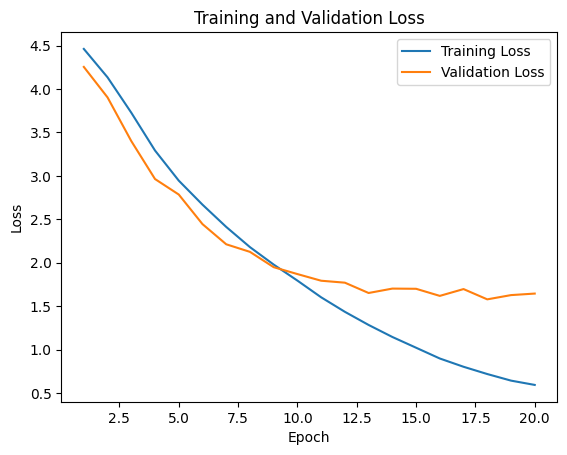

In [16]:

# Load the training results 
df = pd.read_csv("training_results.csv")

# Plot training and validation loss
plt.plot(df['Epoch'], df['Train Loss'], label='Training Loss')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [17]:
# Test model on test set
predicted_labels = []
actual_labels = []

model.eval()  # Set the model to evaluation mode
with torch.inference_mode():  # no gradients are computed
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

Model Accuracy: 61.40%
Model Precision: 64.42%
Model Recall: 61.40%
Model F1 Score: 60.18%
              precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.14      0.20      0.17         5
           2       0.33      0.20      0.25         5
           3       0.71      1.00      0.83         5
           4       1.00      0.60      0.75         5
           5       0.57      0.80      0.67         5
           6       1.00      0.60      0.75         5
           7       0.60      0.60      0.60         5
           8       0.75      0.60      0.67         5
           9       0.57      0.80      0.67         5
          10       1.00      0.60      0.75         5
          11       0.83      1.00      0.91         5
          12       0.00      0.00      0.00         5
          13       0.60      0.60      0.60         5
          14       0.33      0.20      0.25         5
          15       0.80      0.80      0.80 

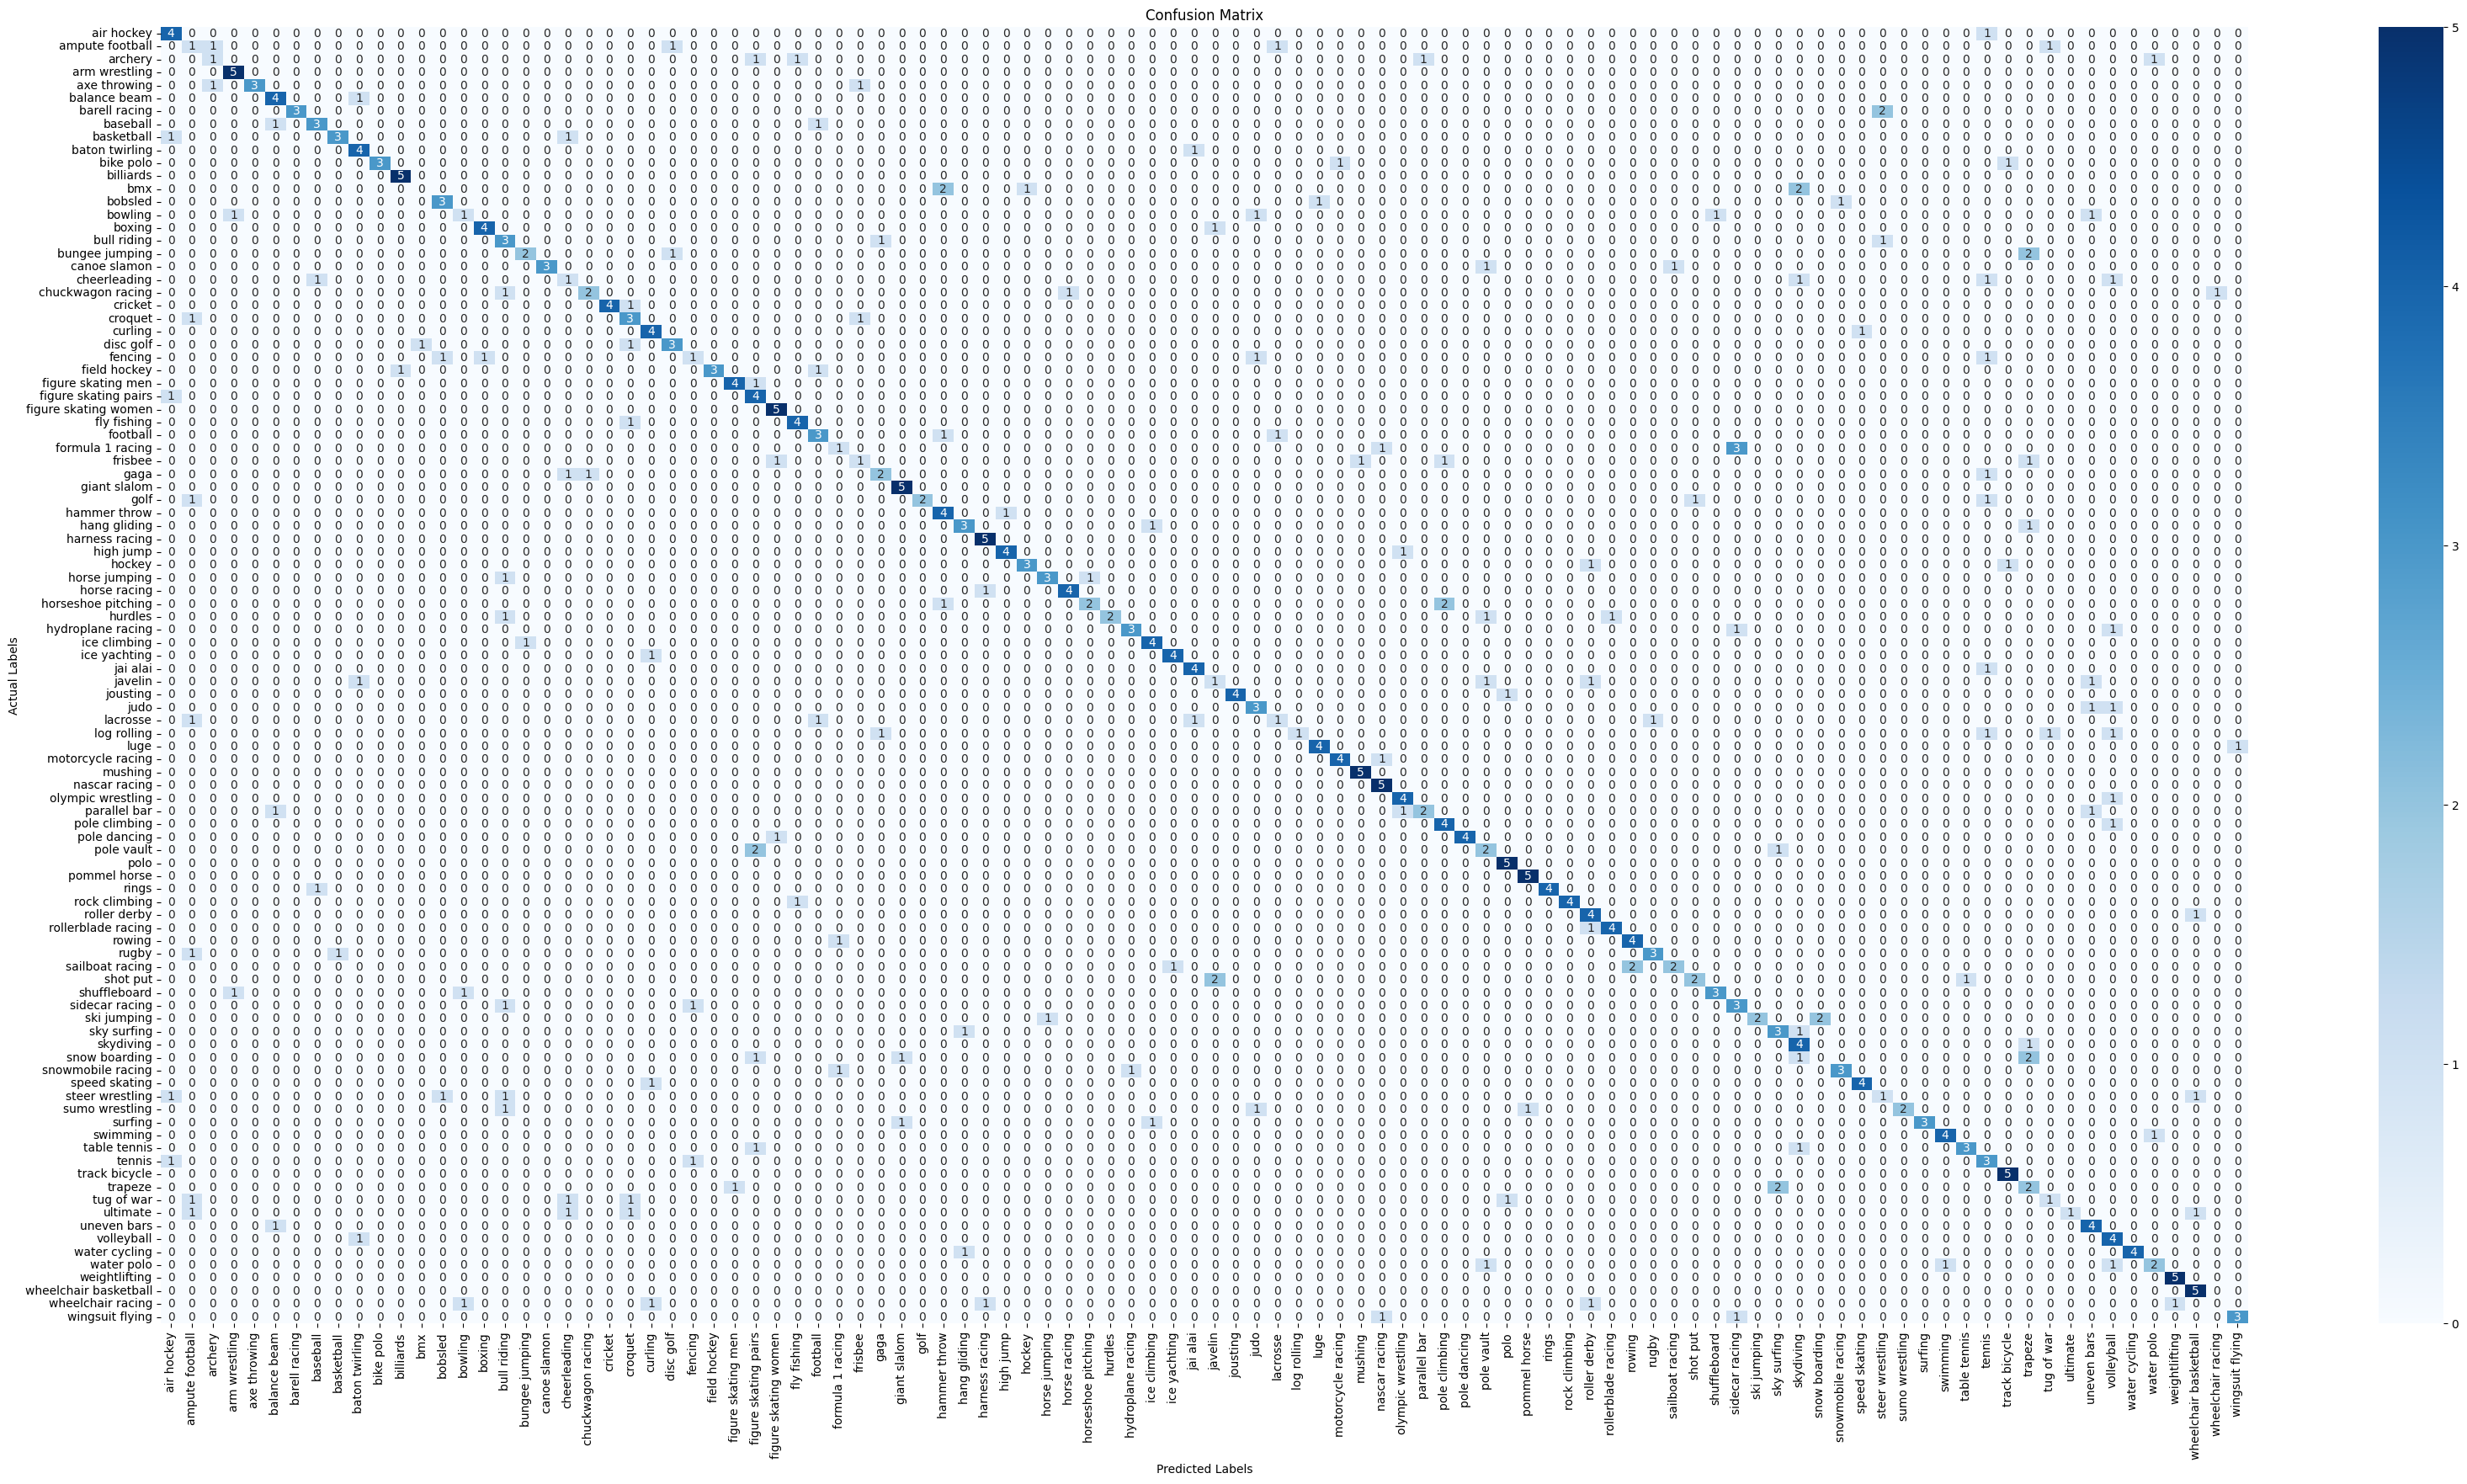

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Calculate evaluation metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, average='weighted', zero_division=0)

# Print metrics
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print(f"Model Precision: {precision * 100:.2f}%")
print(f"Model Recall: {recall * 100:.2f}%")
print(f"Model F1 Score: {f1 * 100:.2f}%")

# Print classification report
print(classification_report(actual_labels, predicted_labels, zero_division=0))

# Generate and visualize confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
class_names = test_dataloader.dataset.classes

plt.figure(figsize=(40, 20))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0


In [20]:
train_data_dir = "/Users/muzaf/OneDrive/Masaüstü/BI2/Term_project/100image/train"
valid_data_dir = "/Users/muzaf/OneDrive/Masaüstü/BI2/Term_project/100image/valid"
test_data_dir = "/Users/muzaf/OneDrive/Masaüstü/BI2/Term_project/100image/test"

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up the data generators
train_datagen = ImageDataGenerator( zoom_range=0.2,
                            width_shift_range=0.2,height_shift_range=0.2)  # maybe rescale needed


# Create the training data generator
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    class_mode='categorical',# Path to your dataset
                                                    target_size=(224, 224),   # Resize images to 299x299
                                                    batch_size=64,
                                                    shuffle = True,
                                                    seed = 42)


Found 13492 images belonging to 100 classes.


In [22]:
# Create the validation data generator
val_datagen = ImageDataGenerator() #maybe rescale needed
validation_generator = val_datagen.flow_from_directory(valid_data_dir, 
                                                       class_mode='categorical',
                                                       target_size=(224, 224),
                                                       batch_size=64,
                                                       shuffle = False,
                                                       seed = 42)


Found 500 images belonging to 100 classes.


In [23]:
test_generator = val_datagen.flow_from_directory(test_data_dir, 
                                                class_mode='categorical',
                                                target_size=(224, 224),
                                                batch_size=64,
                                                shuffle = False,
                                                seed = 42)

Found 500 images belonging to 100 classes.


In [24]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define the EfficientNetB0-based model
def EfficientNetB0Model(num_classes=100):
    # Load the pretrained EfficientNetB0 model with ImageNet weights
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base model's layers to prevent updating during training (optional, you can fine-tune later)
    base_model.trainable = False
    
    # Add custom classification layers on top of the base model
    x = GlobalAveragePooling2D()(base_model.output)  # Pooling layer to reduce dimensionality
    x = Dropout(0.2)(x)  # Apply dropout for regularization
    predictions = Dense(units= 100, activation='softmax')(x)  # Output layer with num_classes
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

# Create the model for 100 classes
model_e = EfficientNetB0Model(num_classes=100)

# Compile the model
model_e.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are not one-hot encoded
                metrics=['accuracy'])

# Print the summary of the model
model_e.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,177,671 (15.94 MB)

 Trainable params: 128,100 (500.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [25]:
opt = Adam(learning_rate=0.001)
model_e.compile(optimizer=opt,
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

In [26]:
# Train the model
history = model_e.fit(
    train_generator,              # Training data generator
    validation_data=validation_generator,  # Validation data generator
    epochs=10,                    # Number of epochs (adjust based on your needs)
    batch_size=64                 # Batch size (you can also specify this in your generator)
)


c:\Users\muzaf\OneDrive\Masaüstü\BI2\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.4179 - loss: 2.9451 - val_accuracy: 0.8940 - val_loss: 0.6585
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.8496 - loss: 0.7725 - val_accuracy: 0.9340 - val_loss: 0.3686
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.8871 - loss: 0.5193 - val_accuracy: 0.9480 - val_loss: 0.2671
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.9132 - loss: 0.4084 - val_accuracy: 0.9520 - val_loss: 0.2212
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9233 - loss: 0.3436 - val_accuracy: 0.9540 - val_loss: 0.2055
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.9347 - loss: 0.2923 - val_accuracy: 0.9620 - val_loss: 0.1731
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9371 - loss: 0.2712 - val_accuracy: 0.9560 - val_loss: 0.1591
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.9490 - loss: 0.2299 - val_accu

In [27]:
# Alternatively, you can save the model in TensorFlow's SavedModel format
model_e.save('efficientnetb0_model.h5')  # This will save it in a directory with SavedModel format

In [28]:
# To load the model back
from tensorflow.keras.models import load_model

model_e_loaded = load_model('efficientnetb0_model.h5')  

In [29]:
import pandas as pd

# Extract the history from training
history_dict = history.history

# Create a DataFrame from the history data
history_df = pd.DataFrame(history_dict)

# Save the DataFrame to a CSV file
history_df.to_csv('training_results_for_effic.csv', index=False)


In [30]:
# Step 1: Get predictions on the test data
predictions = model_e.predict(test_generator, verbose=1)

# Step 2: Convert predictions to class labels
predicted_classes = predictions.argmax(axis=-1)

# Step 3: Get true labels from the test data
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Step 4: Create a DataFrame with true labels and predicted labels
results_df = pd.DataFrame({
    'True Label': true_classes,
    'Predicted Label': predicted_classes
})

# Add label names for easier interpretation
results_df['True Label Name'] = results_df['True Label'].map(lambda x: class_labels[x])
results_df['Predicted Label Name'] = results_df['Predicted Label'].map(lambda x: class_labels[x])

# Step 5: Save the results to a CSV file
results_df.to_csv('test_predictions_ef.csv', index=False)

print("Predictions saved to 'test_predictions_ef.csv'")

# Optional: Evaluate the model on the test data
test_loss, test_accuracy = model_e.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 
Predictions saved to 'test_predictions_ef.csv'
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 835ms/step - accuracy: 0.9687 - loss: 0.1060
Test Loss: 0.10404406487941742, Test Accuracy: 0.972000002861023


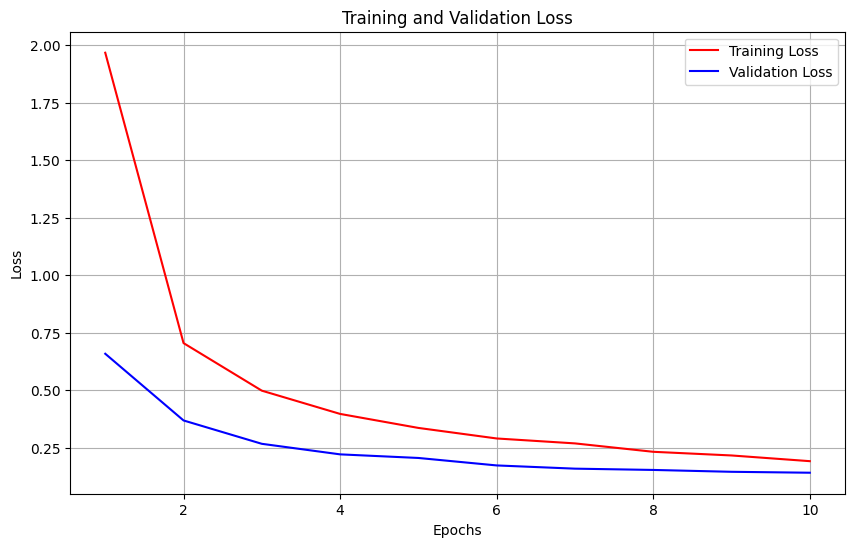

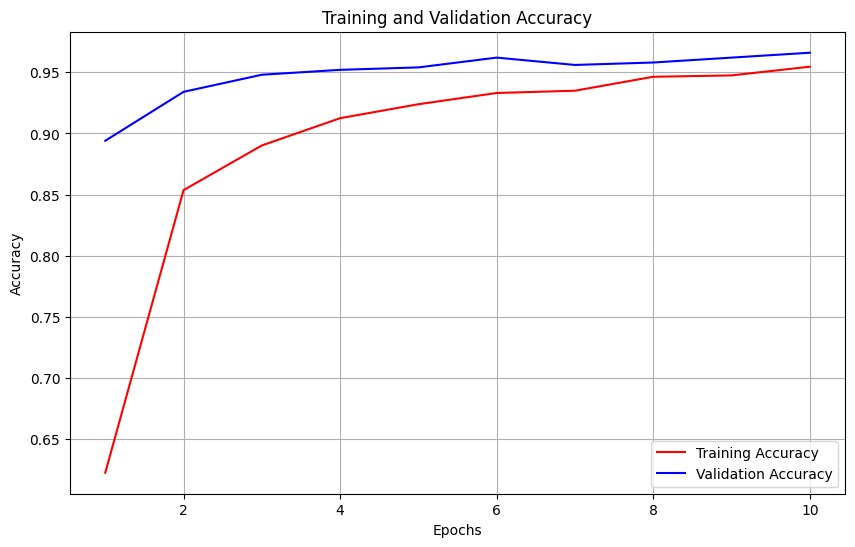

In [31]:
import matplotlib.pyplot as plt

# Extract data from the history object
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot 1: Losses (Training and Validation)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Save the loss plot as a PNG image
plt.savefig('loss_plot.png')

# Plot 2: Accuracies (Training and Validation)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
# Save the accuracy plot as a PNG image
plt.savefig('accuracy_plot.png')

plt.show()


In [35]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

# Step 1: Ensure you have the test data generator (test_generator) and the trained EfficientNetB0 model (model_e)

# Step 2: Get true labels from the test data
true_labels = test_generator.classes  # Extract the true labels from the test data generator

# Step 3: Get predicted labels from the EfficientNetB0 model
predictions = model_e.predict(test_generator)  # Make predictions using EfficientNetB0
predicted_labels = np.argmax(predictions, axis=1)  # Convert predictions to class labels

# Step 4: Generate the classification report as a dictionary
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Step 5: Convert the report dictionary into a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Step 6: Display the DataFrame to get precision, recall, and F1-score for each class
print(report_df)

# Step 7: Optionally, save the table as a CSV file for future analysis
report_df.to_csv('efficientnetb0_classification_report.csv', index=True)

print("Classification report saved to 'efficientnetb0_classification_report.csv'")


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
              precision  recall  f1-score  support
0               1.00000   1.000  1.000000    5.000
1               1.00000   1.000  1.000000    5.000
2               1.00000   1.000  1.000000    5.000
3               1.00000   1.000  1.000000    5.000
4               1.00000   1.000  1.000000    5.000
...                 ...     ...       ...      ...
98              1.00000   1.000  1.000000    5.000
99              1.00000   1.000  1.000000    5.000
accuracy        0.97200   0.972  0.972000    0.972
macro avg       0.97681   0.972  0.971889  500.000
weighted avg    0.97681   0.972  0.971889  500.000

[103 rows x 4 columns]
Classification report saved to 'efficientnetb0_classification_report.csv'
